In [11]:
import pandas as pd
import sqlite3

# Load original dataset
df = pd.read_csv("dataset/WELFake_Dataset.csv")

# Save to SQLite
conn = sqlite3.connect("fake_news.db")
df.to_sql("FakeNewsRaw", conn, if_exists="replace", index=False)
conn.close()

print("Data loaded into local SQL database.")

Data loaded into local SQL database.


(72134, 4)
   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                               None   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  


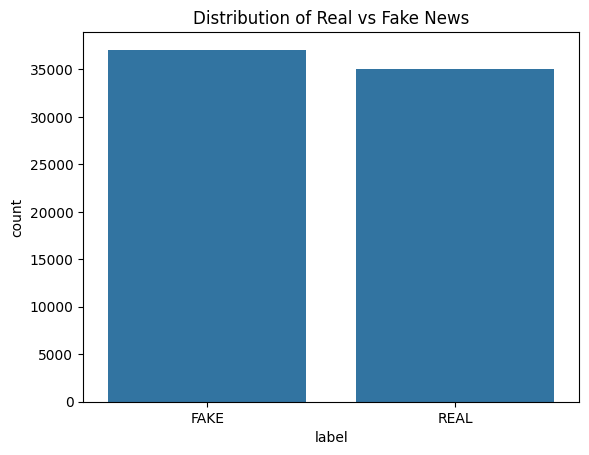

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect("fake_news.db")
df = pd.read_sql("SELECT * FROM FakeNewsRaw", conn)
conn.close()

# Show basic info
print(df.shape)
print(df.head())

# Drop rows with missing values in 'text' or 'label'
df.dropna(subset=['text', 'label'], inplace=True)

# Map label for clarity (optional)
df['label'] = df['label'].map({0: 'REAL', 1: 'FAKE'})

# Check label distribution
sns.countplot(x='label', data=df)
plt.title("Distribution of Real vs Fake News")
plt.show()


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import string

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = str(text).lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_df=0.7)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


[nltk_data] Downloading package stopwords to /Users/nj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.9527012968999237

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.95      0.96      0.95      7409
        REAL       0.95      0.95      0.95      7010

    accuracy                           0.95     14419
   macro avg       0.95      0.95      0.95     14419
weighted avg       0.95      0.95      0.95     14419



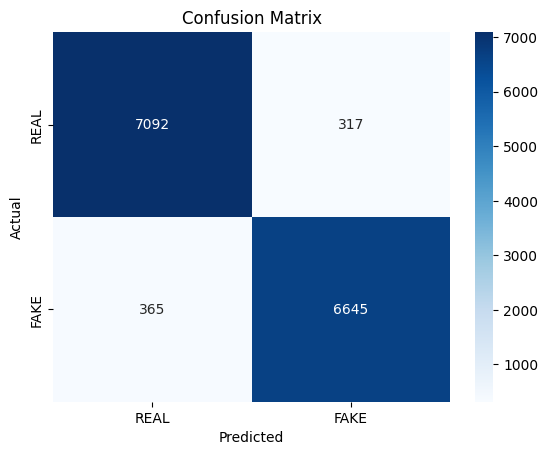

CSV exported.


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train logistic regression
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Predictions
y_pred = model.predict(X_test_vec)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

output_df = pd.DataFrame({
    "text": X_test,
    "actual_label": y_test,
    "predicted_label": y_pred
})

output_df.to_csv("result/fake_news_predictions.csv", index=False)
print("CSV exported.")